In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
from pathlib import Path
import torchaudio
import fairseq
import torch
device = torch.device('cuda')
device

device(type='cuda')

In [3]:
def get_mos_data(split):
    mos_list_file = f'../data/phase1-main/DATA/sets/{split}_mos_list.txt'
    mos_data = {}
    for line in open(mos_list_file):
        file_id, mos = line.rstrip().split(',')
        mos = float(mos)
        mos_data[file_id] = mos
    return mos_data

In [4]:
train_mos_data = get_mos_data('train')
len(train_mos_data)

4974

In [5]:
val_mos_data = get_mos_data('val')
len(val_mos_data)

1066

In [6]:
wav_dir = Path('../data/phase1-main/DATA/wav/')

wavpath = wav_dir / 'sys64e2f-utt9c183cd.wav'
wav = torchaudio.load(wavpath)[0]
wav.size()

torch.Size([1, 42944])

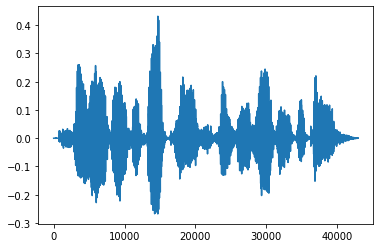

In [7]:
plt.plot(wav.numpy().ravel())

In [8]:
fairseq_base_model = '../fairseq/hubert_base_ls960.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([fairseq_base_model])


2022-02-06 02:42:38 | INFO | fairseq.tasks.hubert_pretraining | current directory is /home/koriyama/voicemos/220131ensemble/voiceMOS2022/notebooks
2022-02-06 02:42:38 | INFO | fairseq.tasks.hubert_pretraining | HubertPretrainingTask Config {'_name': 'hubert_pretraining', 'data': '/checkpoint/wnhsu/data/librispeech/960h/iter/250K_50hz_km100_mp0_65_v2', 'fine_tuning': False, 'labels': ['layer6.km500'], 'label_dir': None, 'label_rate': 50, 'sample_rate': 16000, 'normalize': False, 'enable_padding': False, 'max_keep_size': None, 'max_sample_size': 250000, 'min_sample_size': 32000, 'single_target': False, 'random_crop': True, 'pad_audio': False}
2022-02-06 02:42:38 | INFO | fairseq.models.hubert.hubert | HubertModel Config: {'_name': 'hubert', 'label_rate': 50, 'extractor_mode': default, 'encoder_layers': 12, 'encoder_embed_dim': 768, 'encoder_ffn_embed_dim': 3072, 'encoder_attention_heads': 12, 'activation_fn': gelu, 'dropout': 0.1, 'attention_dropout': 0.1, 'activation_dropout': 0.0, 'enc

In [9]:
ssl_model = model[0]

In [10]:
ssl_model.remove_pretraining_modules()
ssl_model.to(device)
ssl_model.eval();

In [11]:
output_wavs = torch.stack([wav], dim=0)
output_wavs.size()

torch.Size([1, 1, 42944])

In [12]:
res = ssl_model(wav.to(device), mask=False, features_only=True)
res

{'x': tensor([[[-0.0493, -0.2649,  0.3437,  ..., -0.1506,  0.2444, -0.4640],
          [ 0.1350, -0.0583,  0.2559,  ..., -0.2231,  0.1835, -0.9714],
          [-0.1135, -0.5046,  0.2714,  ..., -0.0866,  0.2828,  0.1538],
          ...,
          [-0.0142,  0.2346,  0.2483,  ..., -0.1704,  0.1191, -0.5188],
          [-0.4016,  0.4043, -0.0584,  ...,  0.0918, -0.0666, -1.6404],
          [-0.0805, -0.2125, -0.0082,  ..., -0.1194,  0.0901, -0.6507]]],
        device='cuda:0', grad_fn=<TransposeBackward0>),
 'padding_mask': None,
 'features': tensor([[[-0.5099, -0.1805,  0.0816,  ...,  0.2885, -0.4064,  0.2816],
          [-0.0314, -0.0566, -0.1486,  ..., -0.2360, -0.2566,  0.7784],
          [-0.2184, -0.6378, -0.1077,  ..., -1.0420,  0.0839, -0.8163],
          ...,
          [ 1.2038, -0.1605,  0.0300,  ...,  0.6449, -0.3143,  0.8517],
          [-0.9088, -0.1822,  0.4441,  ..., -1.0349,  0.4286,  0.0110],
          [-0.4622, -0.2534, -0.0989,  ..., -0.4562,  0.8499,  0.0879]]],
      

In [13]:
res['x'].size()

torch.Size([1, 133, 768])

In [14]:
res['features'].size()

torch.Size([1, 133, 768])

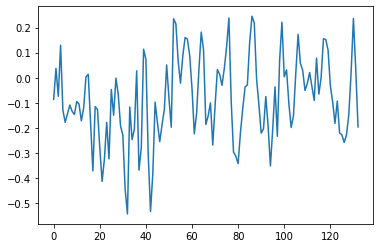

In [15]:
plt.plot(res['x'].squeeze(0)[:, 350].detach().cpu().numpy())

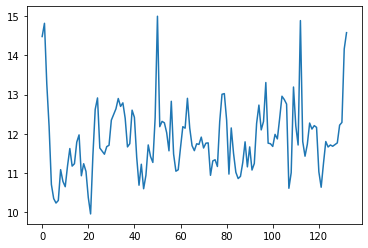

In [16]:
plt.plot(torch.linalg.vector_norm(res['x'].squeeze(0), dim=1).detach().cpu().numpy())

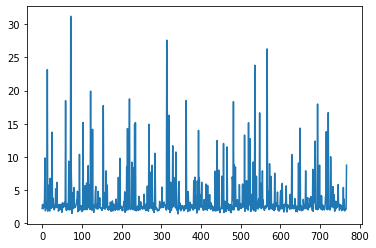

In [17]:
plt.plot(torch.linalg.vector_norm(res['x'].squeeze(0), dim=0).detach().cpu().numpy())

In [18]:
def extract_mean(wavpath):
    with torch.no_grad():
        wav = torchaudio.load(wavpath)[0]
        res = ssl_model(wav.to(device), mask=False, features_only=True)
        return res['x'].squeeze(0).mean(dim=0)


In [19]:
extract_mean(wavpath).size()

torch.Size([768])

In [20]:
out_dir = Path('../out/utt_data/hubert_base')
import os
os.makedirs(out_dir, exist_ok=True)


In [21]:
val_vecs = []
val_moss = []

for key, mos in tqdm(sorted(val_mos_data.items())):
    wavpath = wav_dir / key
    vec = extract_mean(wavpath)
    outpath = out_dir / (wavpath.stem + '.npy')
    
    vec = vec.detach().cpu().numpy()
    np.save(outpath, vec)
    
    val_vecs.append(vec)
    val_moss.append(mos)

  0%|          | 0/1066 [00:00<?, ?it/s]

In [22]:
train_vecs = []
train_moss = []

for key, mos in tqdm(sorted(train_mos_data.items())):
    wavpath = wav_dir / key
    vec = extract_mean(wavpath)
    outpath = out_dir / (wavpath.stem + '.npy')
    
    vec = vec.detach().cpu().numpy()
    np.save(outpath, vec)
    
    train_vecs.append(vec)
    train_moss.append(mos)

  0%|          | 0/4974 [00:00<?, ?it/s]

In [23]:
train_X = np.array(train_vecs)
train_y = np.array(train_moss)
val_X = np.array(val_vecs)
val_y = np.array(val_moss)
train_X.shape

(4974, 768)

In [24]:
uttemb_dir = Path('../out/utt_emb/hubert_base')
os.makedirs(uttemb_dir)
np.save(uttemb_dir / 'train_X.npy', train_X)
np.save(uttemb_dir / 'train_y.npy', train_y)
np.save(uttemb_dir / 'val_X.npy', val_X)
np.save(uttemb_dir / 'val_y.npy', val_y)